# Bootstrap Explanations with the COMPAS Recidivism Dataset

https://github.com/propublica/compas-analysis/

In [1]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from bootstrap import *

In [11]:
# This code has been adapted from 
# https://github.com/dylan-slack/Modeling-Uncertainty-Local-Explainability

PARAMS = {
    'protected_class': 1,
    'unprotected_class': 0,
    'positive_outcome': 1,
    'negative_outcome': 0
}

def get_and_preprocess_compas_data():
    """Handle processing of COMPAS according to: https://github.com/propublica/compas-analysis
    
    Parameters
    ----------
    params : Params
    Returns
    ----------
    np.ndarray X, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = PARAMS['protected_class']
    UNPROTECTED_CLASS = PARAMS['unprotected_class']
    POSITIVE_OUTCOME = PARAMS['positive_outcome']
    NEGATIVE_OUTCOME = PARAMS['negative_outcome']

    compas_df = pd.read_csv("datasets//compas-scores-two-years.csv", index_col=0)
    compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
                              (compas_df['days_b_screening_arrest'] >= -30) &
                              (compas_df['is_recid'] != -1) &
                              (compas_df['c_charge_degree'] != "O") &
                              (compas_df['score_text'] != "NA")]

    compas_df['length_of_stay'] = (pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days
    X = compas_df[['age', 'c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay']]
    
    # F: Felony, M: Misdemeanor
    X = X.replace({'F':1, 'Female':0, 'M':0, 'Male':1}).copy()

    # if person has high score give them the _positive_ model outcome
    y = np.array([POSITIVE_OUTCOME if score == 'High' else NEGATIVE_OUTCOME for score in compas_df['score_text']])
    sens = X.pop('race')

    # assign African-American as the protected class
    sensitive_attr = np.array(pd.get_dummies(sens).pop('African-American'))
    X['race'] = sensitive_attr

    # make sure everything is lining up
    assert all((sens == 'African-American') == (X['race'] == PROTECTED_CLASS))
    cols = [col for col in X]

    categorical_features = [1,2,3,6]

    output = {
        "X": X.values.astype(float),
        "y": y,
        "feature_names": cols,
        "cat_indices": categorical_features
    }
    
    return output


def process_tabular_data_get_model(data):
    """Processes tabular data + trains random forest classifier."""
    X = data['X']
    y = data['y']
    feature_names = data['feature_names']
    print("Features: ")
    print(feature_names)
    
    cat_indices = data['cat_indices']
    continuous_features = [i for i in range(len(feature_names)) if i not in cat_indices]

    xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)
    
    ss = StandardScaler().fit(xtrain[:,continuous_features])
    xtrain_ss = np.copy(xtrain)
    xtest_ss = np.copy(xtest)
    xtrain_ss[:,continuous_features] = ss.transform(xtrain[:,continuous_features])
    xtest_ss[:,continuous_features] = ss.transform(xtest[:,continuous_features])
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(xtrain_ss, ytrain)

    output = {
        "model": rf,
        "feature_names": feature_names,
        "cat_indices": cat_indices, 
        "xtrain": xtrain,
        "xtest": xtest,
        "ytrain": ytrain,
        "ytest": ytest,
        "scaler": ss, 
        "label": 1,
        "train_acc": rf.score(xtrain_ss, ytrain),
        "test_acc": rf.score(xtest_ss, ytest)
    }
    
    print("\n# training samples: ", xtrain.shape[0])
    print("# test samples:     ", xtest.shape[0])
    
    print("\n")
    print(f"Train accuracy: {output['train_acc']}")
    print(f"Test accuracy: {output['test_acc']}")

    return output

In [12]:
compas = get_and_preprocess_compas_data()
X = compas['X']
y = compas['y']

# Train a random forest regressor
data_and_model = process_tabular_data_get_model(compas)

rf = data_and_model['model']
feature_names = data_and_model['feature_names']
num_features = len(feature_names)
categorical_features = data_and_model['cat_indices']
continuous_features = [i for i in range(num_features) if i not in categorical_features]
X_train = data_and_model['xtrain']
y_train = data_and_model['ytrain']
y_test = data_and_model['ytest']
X_test = data_and_model['xtest']
ss = data_and_model['scaler']
feat_types = {i:'continuous' if i in continuous_features else 'categorical' for i in range(num_features)}

print("# training samples: ", X_train.shape[0])
print("# test samples:     ", X_test.shape[0])
print("Train accuracy:     ", data_and_model['train_acc'])
print("Test accuracy:      ", data_and_model['test_acc'])

Features: 
['age', 'two_year_recid', 'c_charge_degree', 'sex', 'priors_count', 'length_of_stay', 'race']

# training samples:  4937
# test samples:      1235


Train accuracy: 0.9793396799675916
Test accuracy: 0.8291497975708502
# training samples:  4937
# test samples:      1235
Train accuracy:      0.9793396799675916
Test accuracy:       0.8291497975708502


## Example explanation using BootstrapTabularExplainer

In [28]:
# Specify parameters
M = 150  # neighborhood size
K = 2    # local polynomial degree 

In [36]:
samples_in = np.copy(X)
samples_out = ground_truth(X) # probabilities predicted by the model

deltas = {0:2, 4:2, 5:1} # maps continuous features to the deltas we should use to compute function differences

bte = BootstrapTabularExplainer(data=samples_in, 
                                model_outputs=samples_out, 
                                mode='classification', 
                                feature_names=feature_names, 
                                categorical_features=categorical_features,
                                category_names={1:['No','Yes'], 2:['Misdemeanor','Felony'], 3:['Female', 'Male'], 6:['Non-AA', 'AA']},
                                explanation_type='diffs', 
                                deltas=deltas)


Local model explanation (# neighbors=100, polynomial degree=2, # parameters=26, R-squared=0.61076): 
Bootstrap method:  percentile


Feature:  age = 26.0
Importance score:  -0.33732
Bootstrap confidence interval:  [-0.49258, -0.15806],  Width=0.33453


Feature:  two_year_recid = Yes
Baseline category:  No
Importance score:  0.45453
Bootstrap confidence interval:  [-0.14354, 0.67452],  Width=0.81805


Feature:  c_charge_degree = Misdemeanor
Baseline category:  Felony
Importance score:  -0.07145
Bootstrap confidence interval:  [-0.27844, 0.09754],  Width=0.37599


Feature:  sex = Male
Baseline category:  Female
Importance score:  0.28814
Bootstrap confidence interval:  [-0.34795, 0.72547],  Width=1.07342


Feature:  priors_count = 9.0
Importance score:  -0.05317
Bootstrap confidence interval:  [-0.57794, 0.36298],  Width=0.94092


Feature:  length_of_stay = 1.0
Importance score:  0.02538
Bootstrap confidence interval:  [-0.06729, 0.13606],  Width=0.20335


Feature:  race = AA
Baseline c

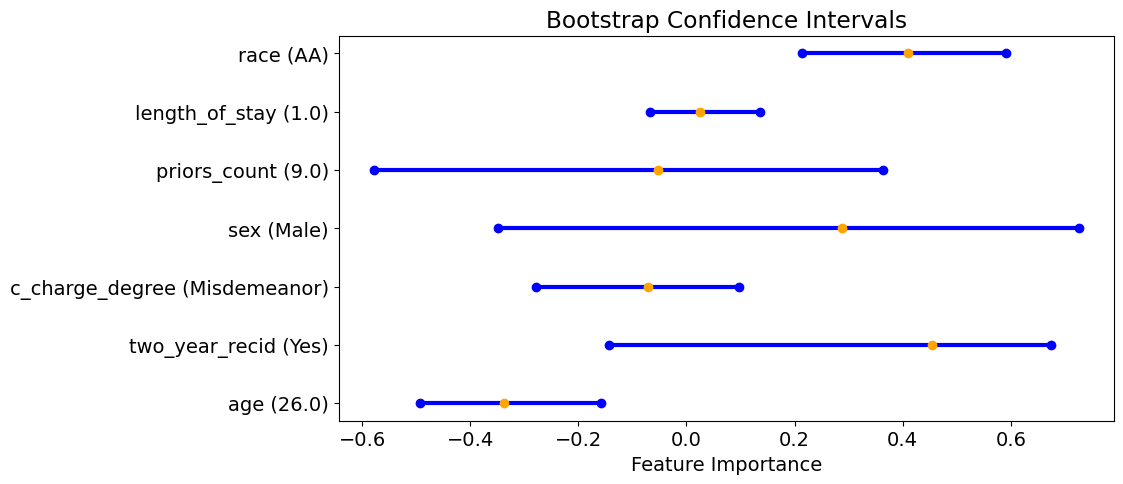

In [37]:
true_diffs = bte.get_diffs(ground_truth, query)
explanation = bte.explain_instance(query, m=M, k=K, verbose=True, with_confidence=True, boot_ratio=0.667)

## Meta explanations

In [101]:
# Construct explanations for all points in the dataset (takes a while) 
all_explanations = [None for i in range(len(X_test))]

for i in range(len(X_test)):
    print(i, end='\r')
    query = X_test[i,:]
    explanation = bte.explain_instance(query, m=M, k=K, verbose=False, with_confidence=True, boot_ratio=0.667)
    all_explanations[i] = explanation

In [102]:
# Compute average feature importances scores and average interval widths over all points in the dataset
num_explanations = len(all_explanations)
scores = [0 for i in range(num_features)]
widths = [0 for i in range(num_features)]

for explanation in all_explanations:
    for i in range(len(explanation)):
        scores[i] += np.abs(explanation[i]['importance'])/num_explanations
        widths[i] += (explanation[i]['upper_confidence'] - explanation[i]['lower_confidence'])/num_explanations

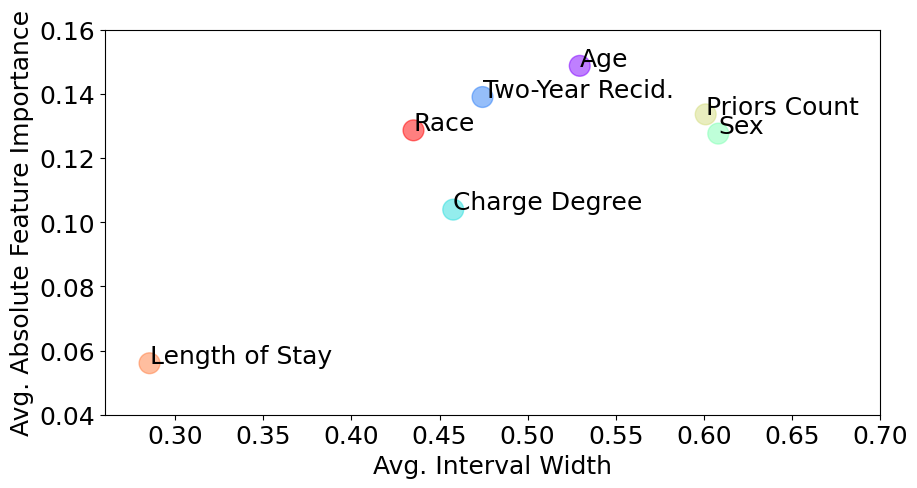

In [104]:
import matplotlib.cm as cm
plt.rcParams.update({'font.size': 18})

# Scatterplot of avg. feature importances and avg. interval widths
area = (30 * 0.5)**2  
colors = cm.rainbow(np.linspace(0, 1, num_features))
fig, ax = plt.subplots()
ax.scatter(widths, scores, s=area, c=colors, alpha=0.5)
for i, txt in enumerate(['Age', 'Two-Year Recid.', 'Charge Degree', 'Sex', 'Priors Count', 'Length of Stay', 'Race']):
    ax.annotate(txt, (widths[i], scores[i]))
plt.xlabel("Avg. Interval Width")
plt.ylabel("Avg. Absolute Feature Importance")
plt.xlim([0.26,0.7])
plt.ylim([0.04,.16])
plt.savefig('figs/compas-recidivism.png', bbox_inches='tight')
plt.show()